In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Layers

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [4]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower]).astype(np.float32)
images.shape

(2, 427, 640, 3)

## Convolution Layer

(2, 427, 640, 3)


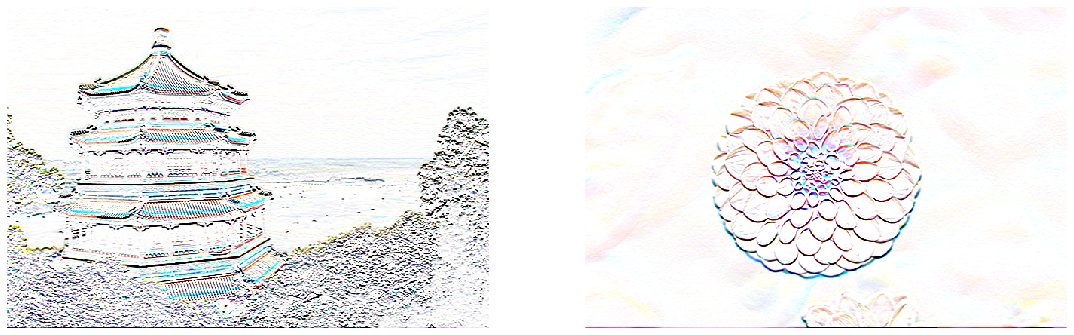

In [ ]:
# Top sobel filter for 2D convolution
my_top_sobel_filter = np.zeros((3, 3, 3, 3))
for channel in (0, 1, 2):
    my_top_sobel_filter[0, (0, 2), channel, channel] = 1
    my_top_sobel_filter[0, 1, channel, channel] = 2
    my_top_sobel_filter[2, (0, 2), channel, channel] = -1
    my_top_sobel_filter[2, 1, channel, channel] = -2

outputs = tf.nn.conv2d(images, my_top_sobel_filter, strides=1, padding='SAME')
print(outputs.shape)


# Plot
fig, axs = plt.subplots(1, 2, figsize=(19, 32))

plt.sca(axs[0])
plot_color_image(1-np.clip(outputs[0].numpy(), 0, 1))

plt.sca(axs[1])
plot_color_image(1-np.clip(outputs[1].numpy(), 0, 1))

plt.show()

## Pooling layer

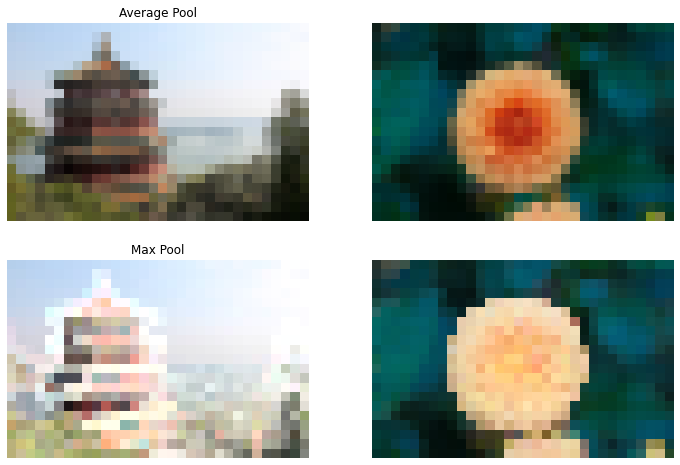

In [ ]:
import matplotlib as mpl

avg_pool = keras.layers.AvgPool2D(pool_size=20)
max_pool = keras.layers.MaxPool2D(pool_size=20)
output_avg = avg_pool(images)
output_max = max_pool(images)


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()

plt.sca(axs[0])
plot_color_image(output_avg[0])
plt.title('Average Pool')
plt.axis("off")

plt.sca(axs[1])
plot_color_image(output_avg[1])
plt.axis("off")

plt.sca(axs[2])
plt.title('Max Pool')
plot_color_image(output_max[0])
plt.axis("off")

plt.sca(axs[3])
plot_color_image(output_max[1])
plt.axis("off")

plt.show()

Global average pool: tf.Tensor(
[[0.5675281  0.57046425 0.552622  ]
 [0.21621236 0.2885447  0.22353025]], shape=(2, 3), dtype=float32)


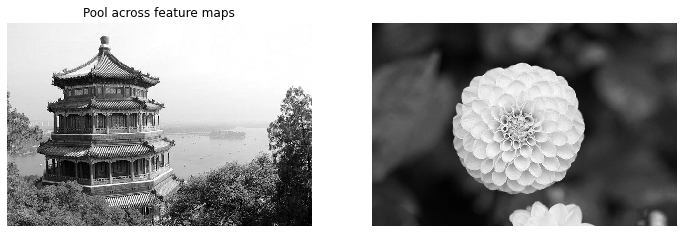

In [ ]:
with tf.device('/cpu:0'): # Not implemented for GPU
    features_output = tf.nn.max_pool(
        images,
        ksize=(1, 1, 1, 3),
        strides=(1, 1, 1, 3),
        padding='VALID'
    )
global_avg_pool = keras.layers.GlobalAvgPool2D()
output_global_avg = global_avg_pool(images)


fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs = axs.ravel()

plt.sca(axs[0])
plot_image(features_output[0].numpy().squeeze())
plt.title('Pool across feature maps')
plt.axis("off")

plt.sca(axs[1])
plot_image(features_output[1].numpy().squeeze())
plt.axis("off")

# Reduces every feature map to its mean
print('Global average pool:', output_global_avg)

plt.show()

## Transposed Convolutional Layer (Deconvolutional layer)

In [ ]:
tf.random.set_seed(42)

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(images)
print(images.shape, output.shape)

(2, 427, 640, 3) (2, 855, 1281, 5)


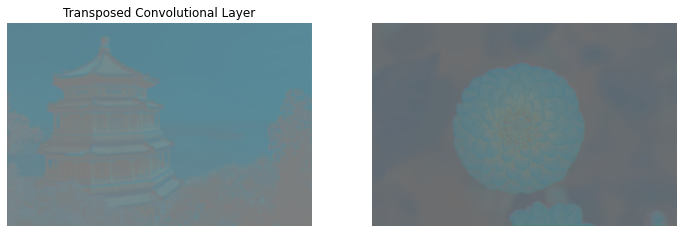

In [ ]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))


fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs = axs.ravel()

plt.sca(axs[0])
plt.title('Transposed Convolutional Layer')
plt.imshow(normalize(output[0, ..., :3]), interpolation='bicubic')
plt.axis("off")

plt.sca(axs[1])
plt.imshow(normalize(output[1, ..., :3]), interpolation='bicubic')
plt.axis("off")

plt.show()

# Training

## Custom

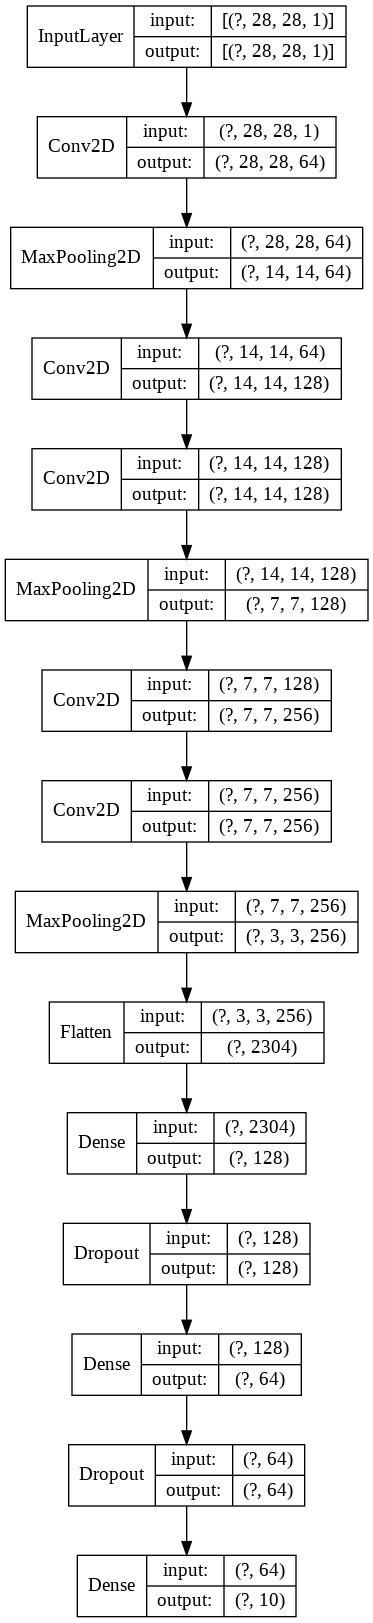

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28, 28, 1]),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax'),
])

keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.7188 - accuracy: 0.7492 - val_loss: 0.3824 - val_accuracy: 0.8630
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4276 - accuracy: 0.8572 - val_loss: 0.3360 - val_accuracy: 0.8776
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3632 - accuracy: 0.8782 - val_loss: 0.3091 - val_accuracy: 0.8866
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3328 - accuracy: 0.8874 - val_loss: 0.2930 - val_accuracy: 0.8944
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3131 - accuracy: 0.8951 - val_loss: 0.2908 - val_accuracy: 0.8958
Epoch 6/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2944 - accuracy: 0.9001 - val_loss: 0.2833 - val_accuracy: 0.8986
Epoch 7/10
1719/1719 [==============================] - 13s 8ms/ste

In [ ]:
score = model.evaluate(X_test, y_test)
print('Accuracy', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3023 - accuracy: 0.8978
Accuracy 0.8978000283241272


## ResNet-34

In [ ]:
from functools import partial

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)

        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        return self.activation(Z + skip_Z)

model = keras.models.Sequential()
model.add(DefaultConv2D(64, strides=2, kernel_size=7, input_shape=[28, 28, 1])) # Original shape is: input_shape=[224, 224, 3])
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 7, 7, 64)          7

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 205s 119ms/step - loss: 0.5188 - accuracy: 0.8204 - val_loss: 0.3843 - val_accuracy: 0.8646
Epoch 2/10
1719/1719 [==============================] - 204s 119ms/step - loss: 0.3507 - accuracy: 0.8760 - val_loss: 0.3516 - val_accuracy: 0.8734
Epoch 3/10
1719/1719 [==============================] - 204s 119ms/step - loss: 0.3064 - accuracy: 0.8893 - val_loss: 0.3287 - val_accuracy: 0.8796
Epoch 4/10
1719/1719 [==============================] - 204s 119ms/step - loss: 0.2785 - accuracy: 0.8996 - val_loss: 0.2689 - val_accuracy: 0.9000
Epoch 5/10
  23/1719 [..............................] - ETA: 3:10 - loss: 0.2186 - accuracy: 0.9253

KeyboardInterrupt: ignored

## Pretrained Res-Net-50

In [ ]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

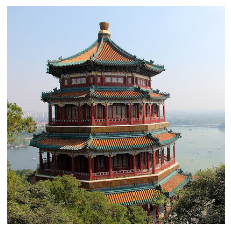

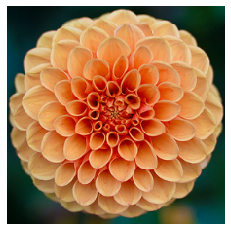

Image #1
palace: 43.39%
bell_cote: 43.07%
monastery: 11.7%


Image #2
vase: 53.96%
cup: 9.52%
daisy: 4.97%




In [ ]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

y_proba = model.predict(inputs)
top_k = keras.applications.resnet50.decode_predictions(y_proba, 3)


for image_index in range(len(images)):
    print(f'Image #{image_index + 1}')

    for _, name, y_proba in top_k[image_index]:
        print(f'{name}: {round(y_proba * 100, 2)}%')

    print('\n')

## Transfer Learning

### Classification

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

print('Classes:', class_names)
print('Size:', dataset_size)

Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Size: 3670


In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

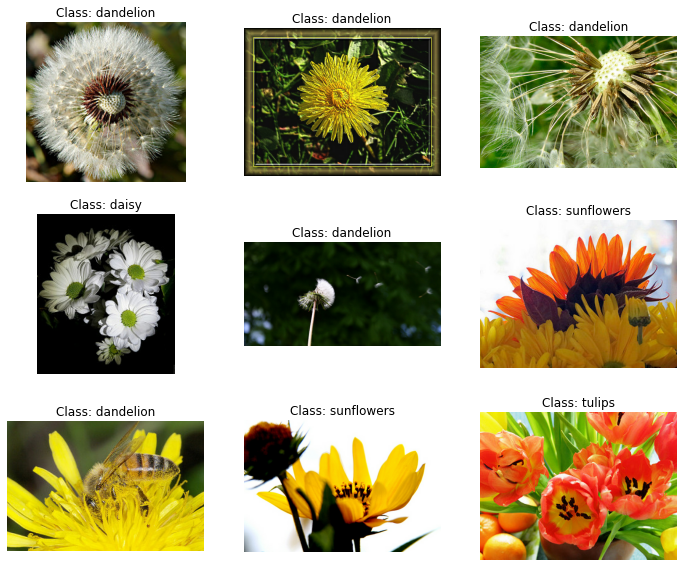

In [ ]:
plt.figure(figsize=(12, 10))
for index, (image, label) in train_set_raw.take(9).enumerate(start=1):
    plt.subplot(3, 3, index.numpy())
    plt.imshow(image)
    plt.title(f'Class: {class_names[label]}')
    plt.axis("off")

plt.show()

In [ ]:
from functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)

    resized = tf.image.resize(cropped_image, [224, 224])
    final = keras.applications.xception.preprocess_input(resized)

    return final, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
base_model = keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet'
)
avg = keras.layers.GlobalAvgPool2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

model.fit(
    train_set,
    steps_per_epoch=int(0.75 * dataset_size / batch_size),
    validation_data=valid_set,
    validation_steps=int(0.15 * dataset_size / batch_size),
    epochs=5
)

Epoch 1/5
86/86 [==============================] - 33s 379ms/step - loss: 0.9562 - accuracy: 0.8121 - val_loss: 0.9678 - val_accuracy: 0.8566
Epoch 2/5
86/86 [==============================] - 32s 368ms/step - loss: 0.3974 - accuracy: 0.9033 - val_loss: 0.7731 - val_accuracy: 0.8474
Epoch 3/5
86/86 [==============================] - 32s 368ms/step - loss: 0.2267 - accuracy: 0.9393 - val_loss: 0.6488 - val_accuracy: 0.8805
Epoch 4/5
86/86 [==============================] - 32s 371ms/step - loss: 0.2017 - accuracy: 0.9426 - val_loss: 0.6080 - val_accuracy: 0.8787
Epoch 5/5
86/86 [==============================] - 32s 368ms/step - loss: 0.1593 - accuracy: 0.9477 - val_loss: 0.6140 - val_accuracy: 0.8732


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

model.fit(
    train_set,
    steps_per_epoch=int(0.75 * dataset_size / batch_size),
    validation_data=valid_set,
    validation_steps=int(0.15 * dataset_size / batch_size),
    epochs=20
)

Epoch 1/20
 2/86 [..............................] - ETA: 51s - loss: 0.7206 - accuracy: 0.7812WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3218s vs `on_train_batch_end` time: 0.8974s). Check your callbacks.


86/86 [==============================] - 110s 1s/step - loss: 0.3182 - accuracy: 0.8899 - val_loss: 0.3944 - val_accuracy: 0.8897
Epoch 2/20
86/86 [==============================] - 110s 1s/step - loss: 0.1236 - accuracy: 0.9589 - val_loss: 0.3646 - val_accuracy: 0.8897
Epoch 3/20
86/86 [==============================] - 110s 1s/step - loss: 0.0587 - accuracy: 0.9840 - val_loss: 0.3263 - val_accuracy: 0.9154
Epoch 4/20
86/86 [==============================] - 110s 1s/step - loss: 0.0466 - accuracy: 0.9855 - val_loss: 0.2711 - val_accuracy: 0.9246
Epoch 5/20
86/86 [==============================] - 110s 1s/step - loss: 0.0257 - accuracy: 0.9909 - val_loss: 0.2838 - val_accuracy: 0.9173
Epoch 6/20
86/86 [==============================] - 110s 1s/step - loss: 0.0210 - accuracy: 0.9935 - val_loss: 0.2703 - val_accuracy: 0.9283
Epoch 7/20
86/86 [==============================] - 110s 1s/step - loss: 0.0274 - accuracy: 0.9909 - val_loss: 0.2955 - val_accuracy: 0.9044
Epoch 8/20
86/86 [======

### ... and Localization (one example at time)

In [ ]:
base_model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False
)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg) # Class
loc_output = keras.layers.Dense(4)(avg) # Location
model = keras.models.Model(
    inputs=base_model.input,
    outputs=[class_output, loc_output]
)
model.compile(
    loss=["sparse_categorical_crossentropy", "mse"],
    loss_weights=[0.8, 0.2], # depends on what you care most about
    optimizer=optimizer,
    metrics=["accuracy"] # Could use tf.keras.metrics.MeanIoU for loc_output
)

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
2/5 [===========>..................] - ETA: 3s - loss: 1.3881 - dense_2_loss: 1.6252 - dense_3_loss: 0.4395 - dense_2_accuracy: 0.2344 - dense_3_accuracy: 0.1562WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3320s vs `on_train_batch_end` time: 0.9471s). Check your callbacks.


5/5 [==============================] - 6s 1s/step - loss: 1.3591 - dense_2_loss: 1.5956 - dense_3_loss: 0.4132 - dense_2_accuracy: 0.2375 - dense_3_accuracy: 0.2125
Epoch 2/2
5/5 [==============================] - 6s 1s/step - loss: 1.2554 - dense_2_loss: 1.4926 - dense_3_loss: 0.3067 - dense_2_accuracy: 0.3812 - dense_3_accuracy: 0.2375


1

# Exercises

## MNIST CNN

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=5, padding='same', input_shape=[28, 28, 1], activation='relu'),
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [ ]:
model.compile('nadam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=1000,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5)
    ],
    validation_data=(X_valid, y_valid)
)

Epoch 1/1000
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3058 - accuracy: 0.9069 - val_loss: 0.0642 - val_accuracy: 0.9826
Epoch 2/1000
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1028 - accuracy: 0.9732 - val_loss: 0.0607 - val_accuracy: 0.9840
Epoch 3/1000
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0768 - accuracy: 0.9799 - val_loss: 0.0460 - val_accuracy: 0.9896
Epoch 4/1000
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0619 - accuracy: 0.9837 - val_loss: 0.0421 - val_accuracy: 0.9890
Epoch 5/1000
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0538 - accuracy: 0.9861 - val_loss: 0.0462 - val_accuracy: 0.9900
Epoch 6/1000
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0454 - accuracy: 0.9882 - val_loss: 0.0493 - val_accuracy: 0.9880
Epoch 7/1000
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0415 - accuracy: 0.9890 - val_loss: 0.0431 -

In [ ]:
print('Test accuracy:', model.evaluate(X_test, y_test)[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0481 - accuracy: 0.9921
Test accuracy: 0.9921000003814697


## Transfer Learning

In [19]:
import tensorflow_datasets as tfds

(test_set_raw, valid_set_raw, train_set_raw), info = tfds.load(
    name='cifar100',
    split=['test', 'train[:15%]', 'train[15%:]'],
    as_supervised=True,
    with_info=True,
)

n_examples = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

In [20]:
from functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)

    resized = tf.image.resize(cropped_image, [224, 224])
    final = keras.applications.xception.preprocess_input(resized)

    return final, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

base_model = keras.applications.xception.Xception(include_top=False, weights='imagenet')
avg_pool = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg_pool)

model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
    optimizer=optimizer
)
model.fit(
    train_set,
    steps_per_epoch=int(n_examples * 0.85 / batch_size) // 2,
    validation_data=valid_set,
    validation_steps=int(n_examples * 0.15 / batch_size) // 2,
    epochs=1000,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3)
    ]
)

In [ ]:
for layer in base_model.layers[-38:]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.01)
model.compile(
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
    optimizer=optimizer
)
model.fit(
    train_set,
    steps_per_epoch=int(n_examples * 0.85 / batch_size) // 2,
    validation_data=valid_set,
    validation_steps=int(n_examples * 0.15 / batch_size),
    epochs=1000,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=2)
    ]
)

In [49]:
print('Test accuracy:', model.evaluate(test_set)[1])

117/117 [==============================] - 38s 325ms/step - loss: 0.8928 - accuracy: 0.7337
Test accuracy: 0.7337072491645813
